<a href="https://colab.research.google.com/github/udita1903/CodeClause/blob/main/LaneLinePipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/udacity/CarND-LaneLines-P1.git

Cloning into 'CarND-LaneLines-P1'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 265 (delta 2), reused 7 (delta 1), pack-reused 254
Receiving objects: 100% (265/265), 43.45 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [ ]:
from distutils.dir_util import copy_tree
import shutil
copy_tree("./CarND-LaneLines-P1/test_images", "./test_images")
copy_tree("./CarND-LaneLines-P1/test_videos", "./test_videos")
shutil.rmtree('./CarND-LaneLines-P1', ignore_errors=False, onerror=None)

In [ ]:

import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
      print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [ ]:
import math
import cv2
import numpy as np

#Making the image gray
def grayscale(img):
  return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

#gaussain smoothing image
def gaussian(img,kernel_size):
  return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)#0 indictes that the standard deviation is automatically found by the Gaussian blur


#canny edge detection
def canny(img,low_threshold,high_threshold):
  return cv2.Canny(img,low_threshold,high_threshold)

#making the image or region or intrest idk
def roi(img,vertices):
  #create a blank image w the same dimentions as the actual image i.e zero array of same dimentions
  #blank image is not the same as a new black image
  blank_image=np.zeros_like(img)
  channel_type=len(img.shape) #grayscale img shape=(height,width), colored image=(h,w,3/4) 3-rgb,4-rgba
  if channel_type>2:
    channel_len=img.shape[2] #will contain either 3 or 4
    mask_color=(255,)*channel_len#not grayscale img
  else:
    mask_color=255

  #determine the color for masking, now fill the region with the color
  cv2.fillPoly(blank_image,vertices,mask_color)#output will a polygon filled w white

  #find the common region between the edges detected and the masked region
  masked_image=cv2.bitwise_and(img,blank_image) #the blank image will already be filled so you are passing a filled image
  #masked_image here contains the common region from the canny edges detected and then the while masked region that is obtained in blank image
  return masked_image

#drawing lines that are obtained from hough transform
def draw_line(img,lines,color=[255,0,0],thickness=10):
  for line in lines:
    for x1,y1,x2,y2 in line:
      cv2.line(img,(x1,y1),(x2,y2),color,thickness)




In [ ]:
#usually based off the image you can pick the roi by yourself by manually entering the vertices of the polygon but you cannot do that for a large number of images, so you will find slope
#and categorize it into left and right lanes, for this you are getting the lines from your hough transform

def slope_line(img,lines):
  #1.make a copy of the image
  image=img.copy()
  polygon_vertices=[]
  order=[0,1,3,2]

  left_lines=[]
  right_lines=[]

  for line in lines:
    for x1,y1,x2,y2 in line:
      if x1==x2:
        pass
      else:
        m=(y2-y1)/(x2-x1)
        c=y1-m*x1

        if m<0:
          left_lines.append((m,c))
        if m>=0:
          right_lines.append((m,c))

  #calculate the mean of the left and right line to get an estimate of the left and right boundaries
  left_line=np.mean(left_lines,axis=0)
  right_line=np.mean(right_lines,axis=0)


  #printing all of the above lines

  for slope,intercept in [left_line,right_line]:
    rows,cols=image.shape[:2]
    y1=int(rows) #height of the image
    y2=int(rows*0.6)
    x1=int((y1-intercept)/slope)
    x2=int((y2-intercept)/slope)
    polygon_vertices.append((x1,y1))
    polygon_vertices.append((x2,y2))
    draw_line(img, np.array([[[x1,y1,x2,y2]]]))


  polygon_vertices = [polygon_vertices[i] for i in order]
  cv2.fillPoly(img, pts = np.array([polygon_vertices],'int32'), color = (0,255,0))
  return cv2.addWeighted(image,0.7,img,0.4,0.)

#Hough transform
def hough(img, rho, theta, threshold, min_line_len, max_line_gap):#resoltion of the grid
  lines=cv2.HoughLinesP(img, rho, theta, threshold,np.array([]), min_line_len, max_line_gap)
  line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)#creates an empty 0s grid same size as input image which is a canny edge line
  line_img = slope_line(line_img,lines)
  return line_img


In [ ]:
def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    return lines_edges

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6]

    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [ ]:
# Lane finding Pipeline
def lane_finding_pipeline(image):

    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = roi(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)

    return output

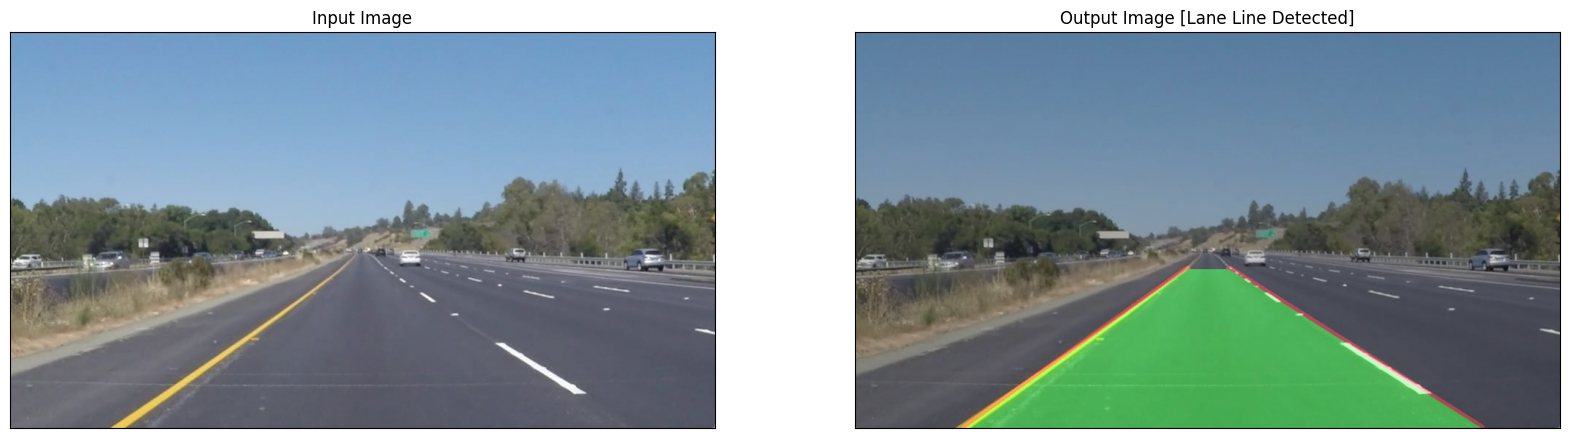

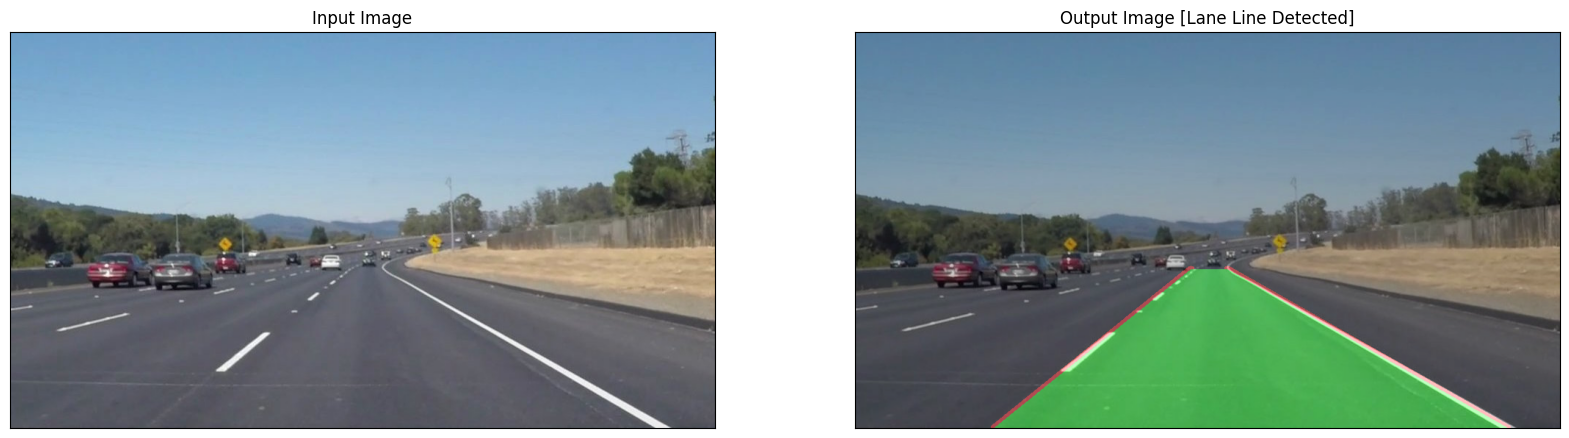

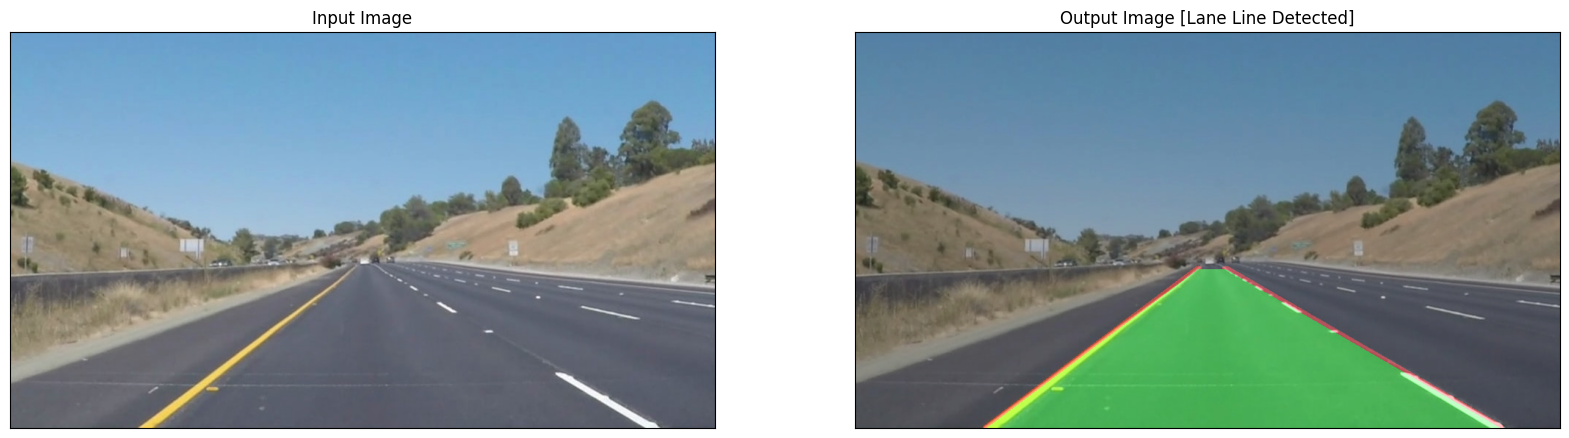

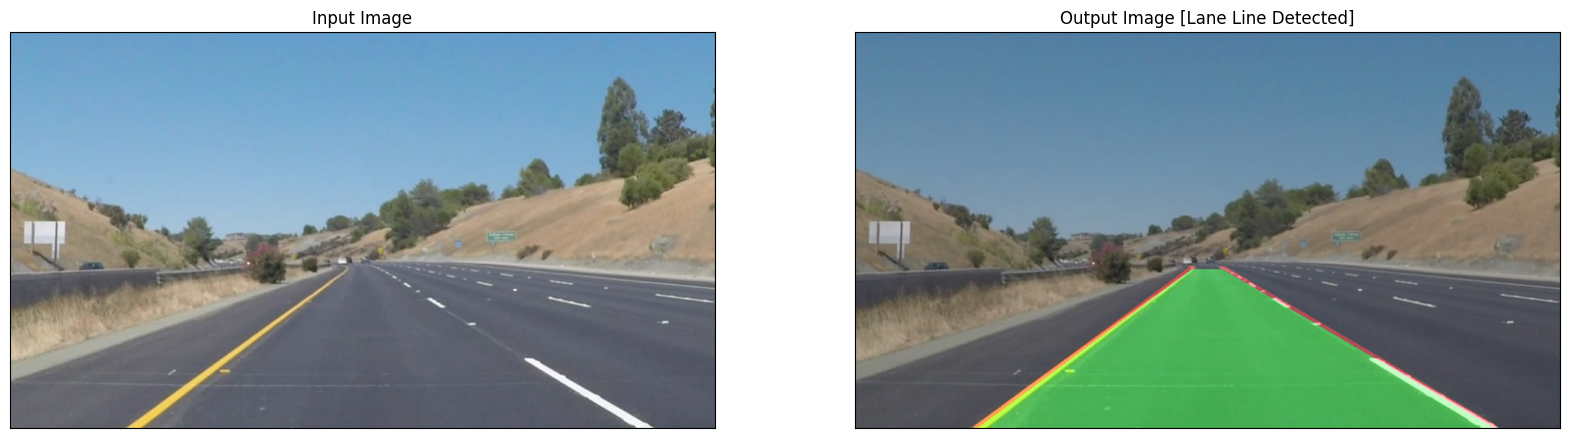

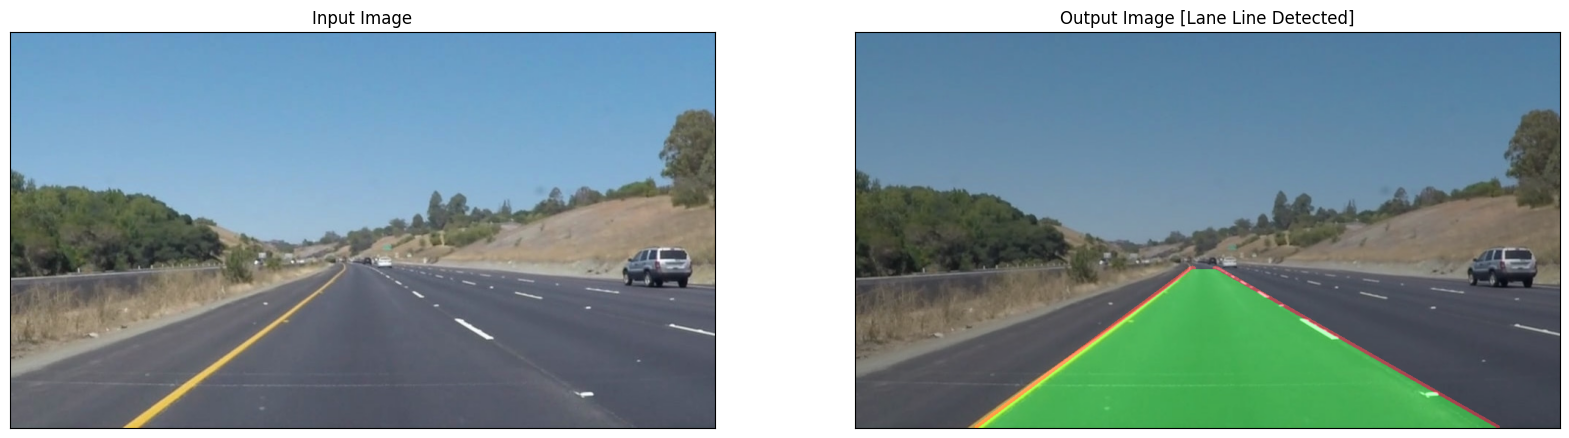

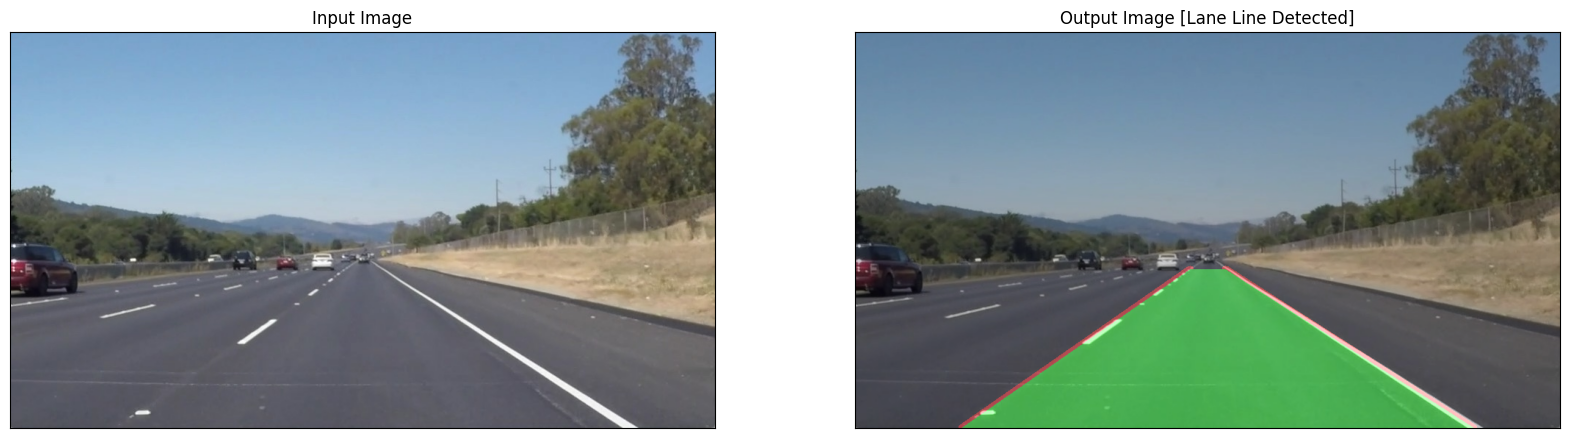

In [ ]:
 for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()